# Affiliation analysis 

We have already explored party affiliations of polititians. This notebook presents affiliation analysis of precise polititians' position in structures in relation to tweets associated with economy.
The possible positions are: 
 - MP: member of Polish parliment,
 - MEP: member of European parliment,
 - LG_member: member of local government,
 - marshall/vicemarshal: marshall or vicemarshall in sejm or senate,
 - Positions_in_Ministries: position in ministries,
 - party_presidents/vice_presidents: presidents or vice presidents of parties,
 - Parliamentary_club_presidents: parliamentary club presidents,
 - Party_Treasurers_Secretaries: treasurers or secretaries of parties.
 

Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib as plt
import tqdm
import fuzzywuzzy
from nltk.sentiment import SentimentIntensityAnalyzer

reading affiliations

In [30]:
df_aff= pd.read_parquet('../data/03.cleaned/df_clean_translated_affiliations.parquet')

print(df_aff.head(2))

                 created_at  \
0 2024-10-15 19:49:34+00:00   
1 2024-10-15 16:12:19+00:00   

                                                text                   id  \
0  @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1  Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   

      author_id                                      edit_controls  \
0  1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1  1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   

   possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0               False       everyone   pl  [1846277256509116623]   
1               False       everyone   pl  [1846222583898784025]   

   conversation_id  ... impression_count  \
0     1.846092e+18  ...             1555   
1     1.846223e+18  ...             3031   

                                       text_clean_en  \
0   Failure to implement most of the "100 specifi...   
1  A year aft

In [16]:
df_combined = pd.read_parquet('../data/03.cleaned/df_combined.parquet')

print(df_combined.head(2))

  reply_settings                created_at  \
0       everyone 2024-10-15 07:13:34+00:00   
1       everyone 2024-10-14 08:46:51+00:00   

                                         attachments  \
0  {'media_keys': ['3_1846083966849159168', '3_18...   
1                                               None   

                                       edit_controls     author_id  \
0  {'editable_until': '2024-10-15 08:12:39+00:00'...  1.284852e+18   
1  {'editable_until': '2024-10-14 09:43:52+00:00'...  1.284852e+18   

                       edit_history_tweet_ids lang  possibly_sensitive  \
0  [1846086770229694583, 1846086999964283214]   pl               False   
1  [1845747336862961872, 1845748090461966651]   pl               False   

                    id  conversation_id  ... reply_count like_count  \
0  1846086999964283136     1.846087e+18  ...          61        644   
1  1845748090461966592     1.845748e+18  ...         169       3845   

  quote_count  impression_count  \
0        

In [6]:
affiliations_df = pd.read_excel('../data/06.analysis/affiliations_polititians.xlsx')

print(affiliations_df.head(2))

                 Name  poseł  europoseł  samorzad  \
0         Donald Tusk      1          0         0   
1  Bartosz Arłukowicz      0          1         0   

   marszalkowie/wicemarszalkowie (sejm + senat)  posady w ministerstwach  \
0                                             0                        0   
1                                             0                        0   

   prezesi/wiceprezesi partii  przewodniczący klubów parlamentarnych  \
0                           1                                      0   
1                           1                                      0   

   skarbnicy/sekretarze partii  
0                            0  
1                            0  


English column names

In [12]:
affiliations_df.rename(columns={
    'poseł': 'MP',
    'europoseł': 'MEP',
    'samorzad': 'LG_member',
    'marszalkowie/wicemarszalkowie (sejm + senat)': 'marshal_vicemarshal',
    'posady w ministerstwach': 'Positions_in_Ministries',
    'prezesi/wiceprezesi partii': 'party_presidents/vice_presidents',
    'przewodniczący klubów parlamentarnych': 'Parliamentary_club_presidents',
    'skarbnicy/sekretarze partii': 'Party_Treasurers_Secretaries'
}, inplace=True)

print(affiliations_df.head(2))

                 Name  MP  MEP  LG_member  marshal_vicemarshal  \
0         Donald Tusk   1    0          0                    0   
1  Bartosz Arłukowicz   0    1          0                    0   

   Positions_in_Ministries  party_presidents/vice_presidents  \
0                        0                                 1   
1                        0                                 1   

   Parliamentary_club_presidents  Party_Treasurers_Secretaries  
0                              0                             0  
1                              0                             0  


EDA of affiliations

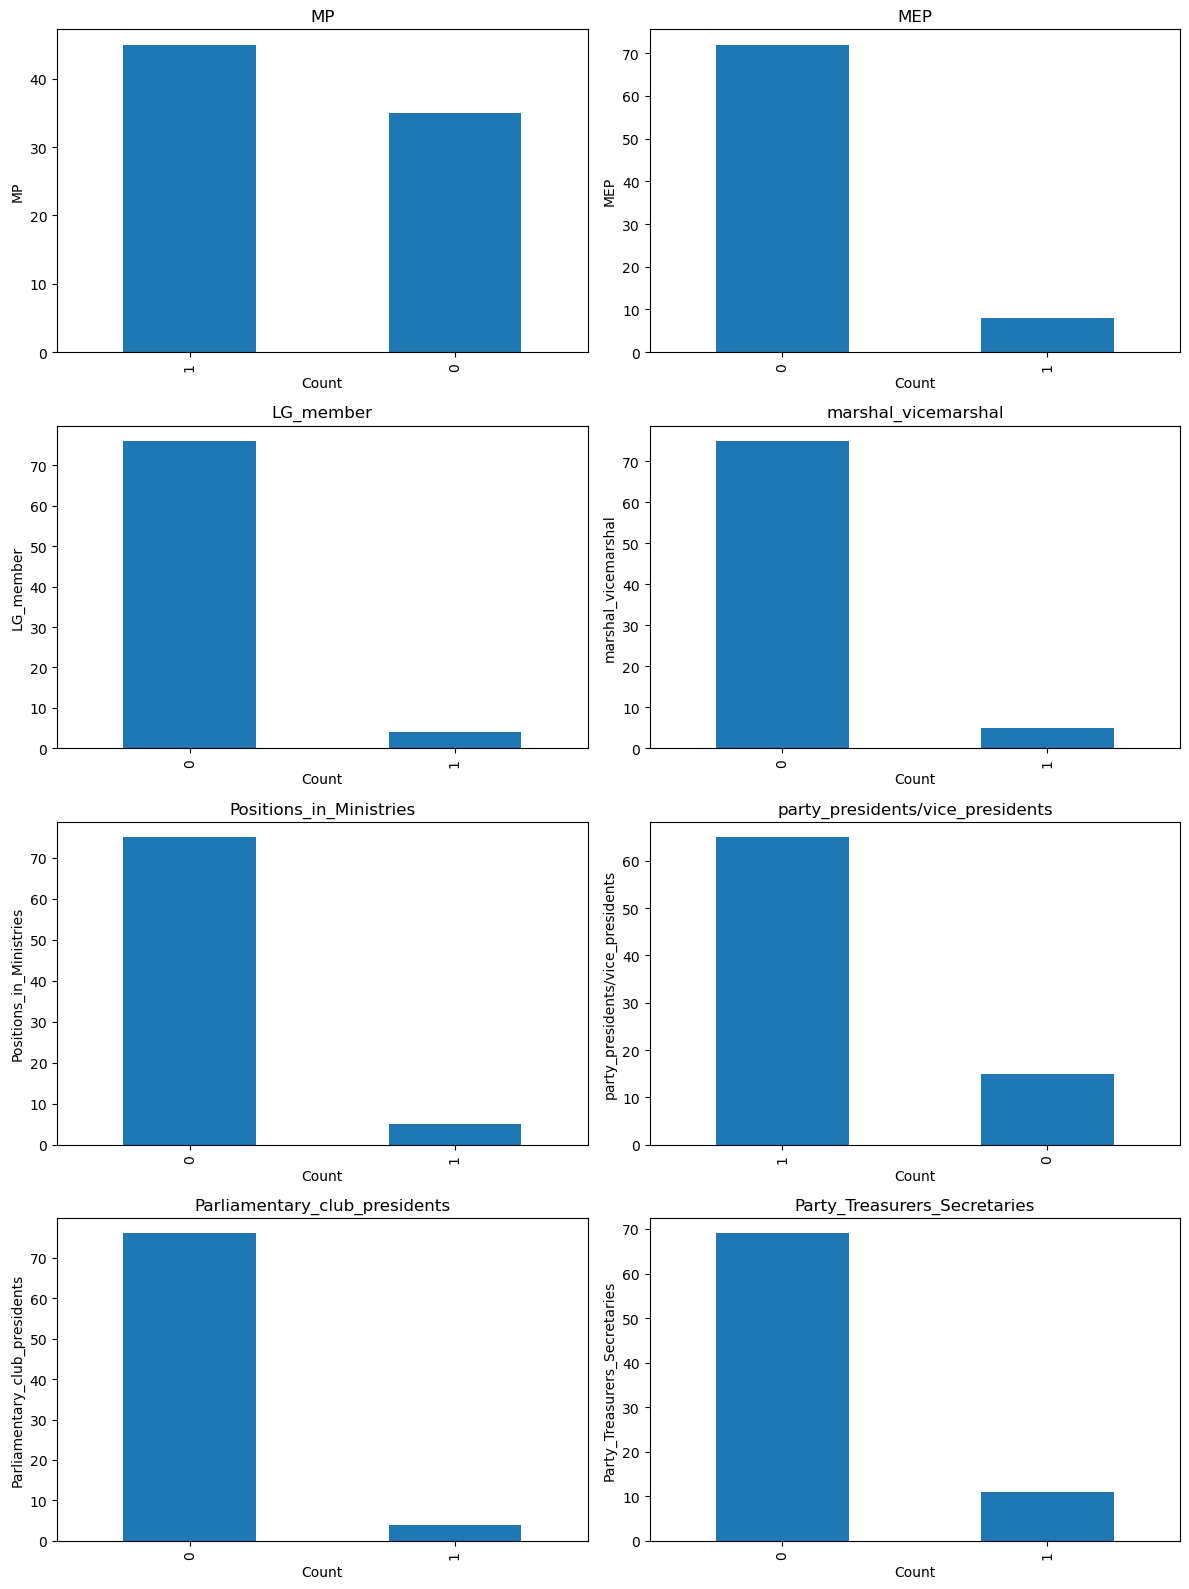

In [15]:
categorical_columns = ['MP', 'MEP', 'LG_member', 'marshal_vicemarshal', 'Positions_in_Ministries', 
                       'party_presidents/vice_presidents', 'Parliamentary_club_presidents', 'Party_Treasurers_Secretaries']

fig, axes = plt.subplots(4, 2, figsize=(12, 16))

axes = axes.flatten()

for idx, column in enumerate(categorical_columns):
    affiliations_df[column].value_counts().plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(column)
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel(column)

plt.tight_layout()
plt.show()

In [25]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm.tqdm(df_combined.iterrows(), total=len(df_combined)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)

vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()
vader_res.rename(columns={'index': 'id', 'neg': 'neg_vader', 'neu': 'neu_vader', 'pos': 'pos_vader', 'compound': 'compound_vader'}, inplace=True)
print("Average sentiment scores:")
print(vader_res.iloc[:, 1:5].mean())
df_no_na = df_combined.merge(vader_res, on='id', how='left')
df_no_na[["username", "name", "text_clean_en", "neg_vader", "neu_vader", "pos_vader", "compound_vader"]].head()

100%|██████████| 48331/48331 [00:11<00:00, 4105.47it/s]


Average sentiment scores:
neg_vader         0.064897
neu_vader         0.783345
pos_vader         0.151343
compound_vader    0.164220
dtype: float64


,username,name,text_clean_en,neg_vader,neu_vader,pos_vader,compound_vader
0,placzekgrzegorz,Grzegorz Płaczek,❌ The Polish government intends to build 49 F...,0.071,0.840,0.089,0.0173
1,placzekgrzegorz,Grzegorz Płaczek,❌ The cesspool is breaking out and it's getti...,0.000,0.896,0.104,0.6549
2,placzekgrzegorz,Grzegorz Płaczek,❌ I DON'T UNDERSTAND HOW YOU CAN HURT YOUR OW...,0.155,0.734,0.111,-0.3453
3,placzekgrzegorz,Grzegorz Płaczek,🆘 The pharmaceutical company GSK will pay ove...,0.164,0.681,0.154,-0.1260
4,placzekgrzegorz,Grzegorz Płaczek,"❌ WHAT IS GOING ON HERE? In October 2024, her...",0.030,0.970,0.000,-0.1027


In [32]:
from fuzzywuzzy import process

# Create a mapping of names from df_aff to affiliations_df using fuzzy matching
name_mapping = {name: process.extractOne(name, affiliations_df['Name'])[0] for name in df_aff['name'].unique()}

# Map the names in df_aff to the closest match in affiliations_df
df_aff['matched_name'] = df_aff['name'].map(name_mapping)

# Perform the merge using the matched names
merged_df = df_aff.merge(affiliations_df, left_on='matched_name', right_on='Name', how='inner')

print(merged_df.head())

                 created_at  \
0 2024-10-15 19:49:34+00:00   
1 2024-10-15 16:12:19+00:00   
2 2024-10-15 12:09:12+00:00   
3 2024-10-15 07:32:44+00:00   
4 2024-10-15 06:27:14+00:00   

                                                text                   id  \
0  @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1  Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2   ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3  Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4              #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   

      author_id                                      edit_controls  \
0  1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1  1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2  1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3  1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   


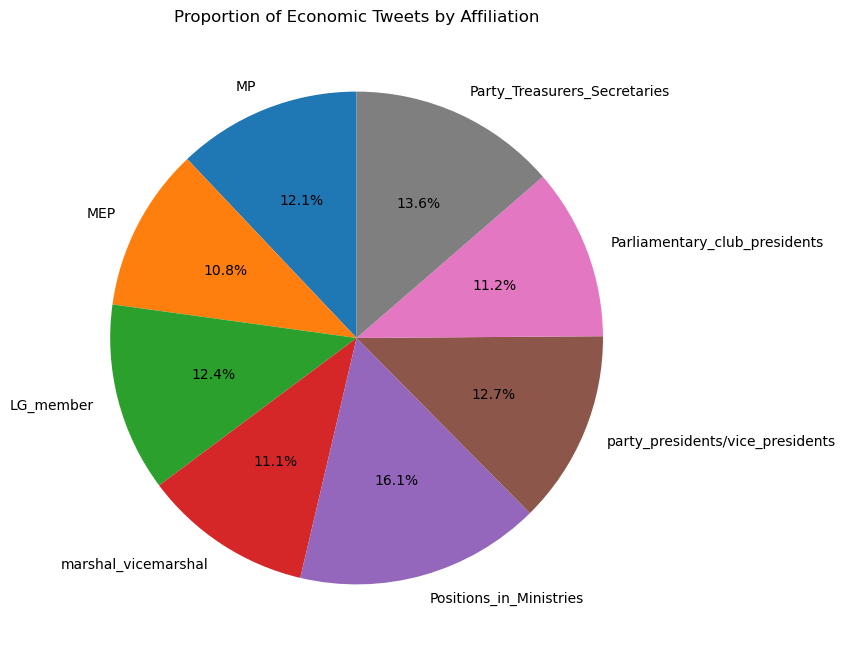

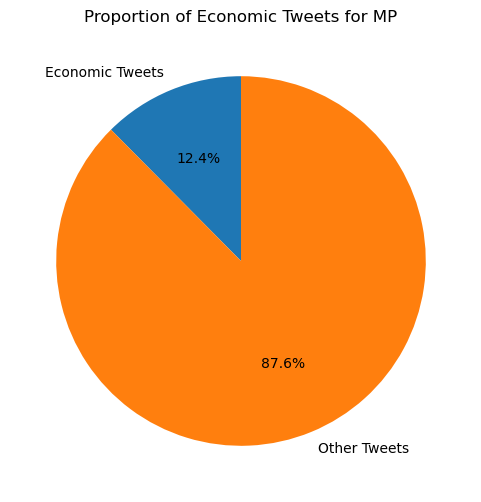

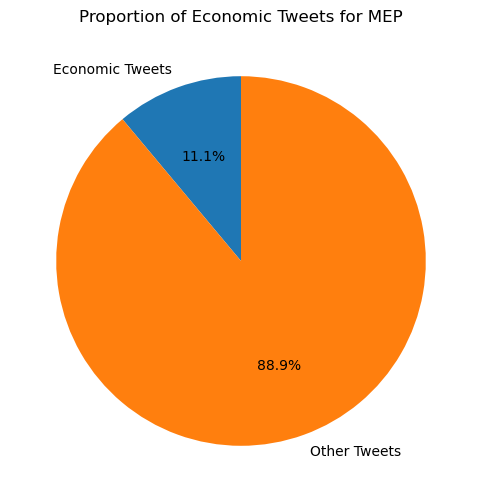

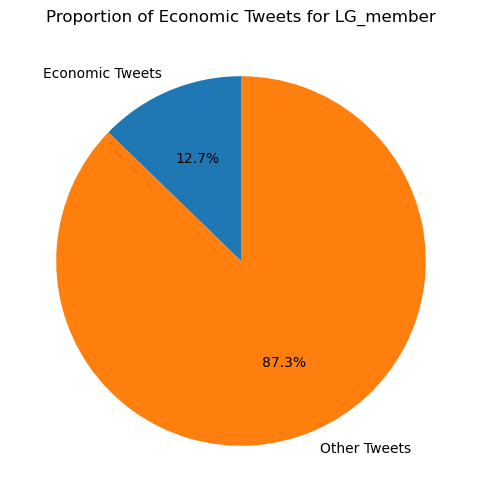

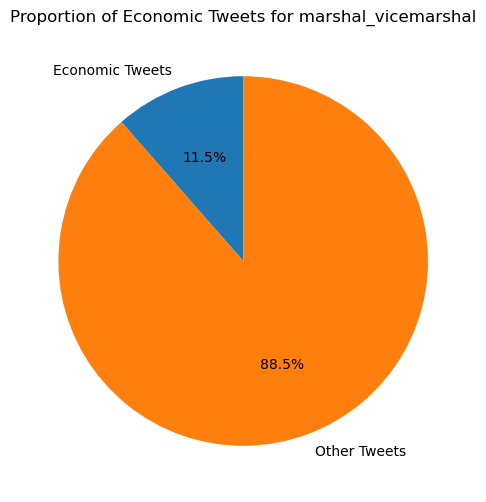

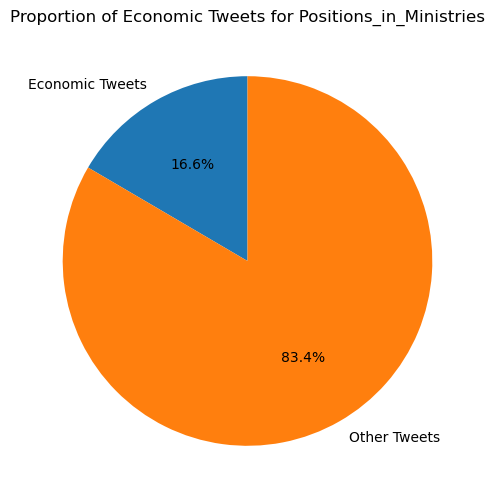

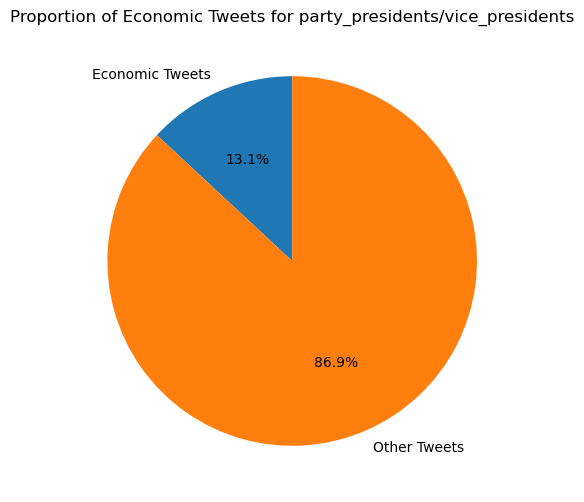

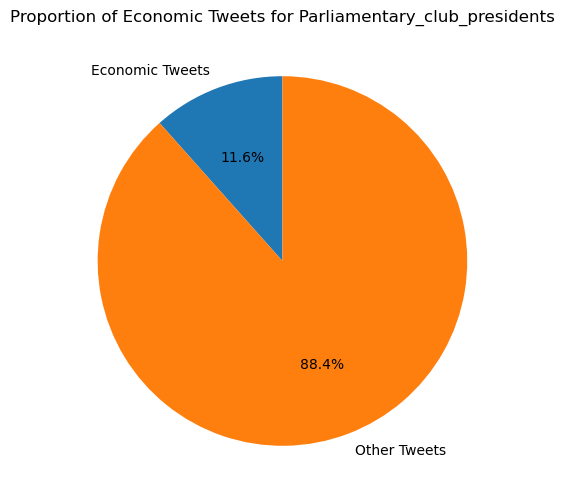

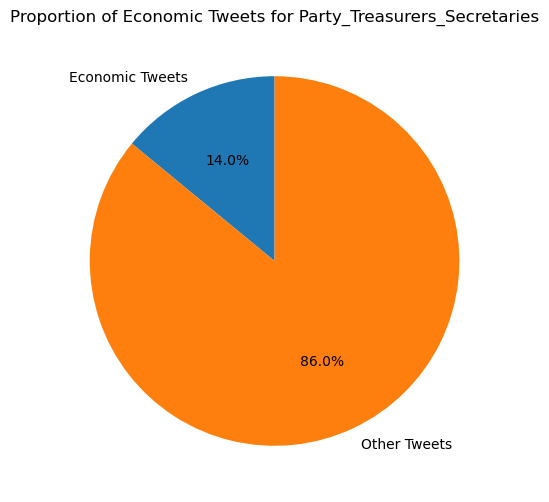

In [34]:
import matplotlib.pyplot as plt

affiliation_columns = ['MP', 'MEP', 'LG_member', 'marshal_vicemarshal', 'Positions_in_Ministries', 
                       'party_presidents/vice_presidents', 'Parliamentary_club_presidents', 'Party_Treasurers_Secretaries']

economic_tweets = merged_df[merged_df['has_econ_term_FILTERED']]

proportions = {}
for column in affiliation_columns:
    total_count = merged_df[column].sum()
    econ_count = economic_tweets[column].sum()
    proportions[column] = econ_count / total_count if total_count > 0 else 0

fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(proportions.values(), labels=proportions.keys(), autopct='%1.1f%%', startangle=90)
ax.set_title('Proportion of Economic Tweets by Affiliation')
plt.show()

for column in affiliation_columns:
    fig, ax = plt.subplots(figsize=(6, 6))
    labels = ['Economic Tweets', 'Other Tweets']
    sizes = [economic_tweets[column].sum(), merged_df[column].sum() - economic_tweets[column].sum()]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Proportion of Economic Tweets for {column}')
    plt.show()